In [ ]:
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay, f1_score
from sklearn.utils.class_weight import compute_sample_weight

!pip install Sastrawi
import Sastrawi
nltk.download('punkt_tab')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preprocessing

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data Skripsi/review_all.xlsx')

In [ ]:
def caseFolding(review):
  review = review.lower()
  return review

df['fold'] = df['textDisplay'].apply(caseFolding)

In [ ]:
def cleaningText(text):
  text = re.sub(r'@[^\s]+', ' ', text) # Menghapus mention
  text = re.sub(r'#[A-Za-z0-9]+', ' ', text) # Menghapus Hashtag
  text = re.sub(r"<.*?>", " ", text) # Menghapus tag html
  text = re.sub(r'RT[\s]', ' ', text) # Menghapus retweet
  text = re.sub(r'http\S+', ' ', text) # Menghapus link http
  text = re.sub(r'https\S+', ' ', text) # Menghapus link https
  text = re.sub(r'(?:&amp;quot;|&quot;|&amp;quot|&quot|&#0*34;|&#34;)', ' ', text) #menghapus tanda kutip
  text = re.sub(r"â€‹", "", text) # Menghapus zero witdh non-joiner
  text = re.sub(r'[0-9]', ' ', text) # Menghapus angka
  text = text.replace('\n', ' ') # Menganti baris baru dengan spasi
  text = re.sub(r'([.,!?()])', ' ', text) # Memberi spasi pada akhir tanda baca
  text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))  # Menghapus tanda baca
  text = re.sub(r'(.)\1{2,}', r'\1\1', text) # Menghapus duplikat huruf
  text = re.sub(r'[^\x00-\x7F]+', ' ', text) # Menghapus non-ASCII
  text = re.sub(r' +', ' ', text) # Menghapus spasi berlebihan
  text = text.strip(' ')  # Menghapus spasi berlebihan di awal dan akhir text
  return text

df['cleaned'] = df['fold'].apply(cleaningText);

In [ ]:
def tokenizingText(review):
  review = word_tokenize(review)
  return review

df['tokens'] = df['cleaned'].apply(tokenizingText)

In [ ]:
norm_df = pd.read_excel('/content/drive/MyDrive/Data Skripsi/kamus_norm.xlsx').astype(str)
norm_dict = dict(zip(norm_df['before'], norm_df['after']))
def normalisasi(str_text):
  return [norm_dict[text] if text in norm_dict else text for text in str_text]

df['normalisasi'] = df['tokens'].apply(normalisasi)

In [ ]:
sw_indo = pd.read_excel('/content/drive/MyDrive/Data Skripsi/sw.xlsx')
sw_indo = sw_indo.squeeze().tolist()
def stopwordsRemoval(tokens):
  cleaned_tokens = []
  for token in tokens:
    if token not in sw_indo:
      cleaned_tokens.append(token)
  return cleaned_tokens
df['stopwords'] = df['normalisasi'].apply(stopwordsRemoval)

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
tqdm.pandas()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text_cleaning):
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    return " ".join(do)

df['stemmed'] = df['stopwords'].progress_apply(stemming)

100%|██████████| 32221/32221 [13:18<00:00, 40.34it/s] 


In [ ]:
df = df.dropna()
df['bersih'] = df['stemmed']

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data Skripsi/hasil_cleaning.xlsx')
df['bersih'] = df['bersih'].astype(str)

## Model

In [ ]:
df_samsung = df[df['jenis'] == 'Samsung']
# df_samsung.head()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=1000)
X = vectorizer.fit_transform(df_samsung['bersih'])
y = df_samsung['sentimen']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12406, 1000), (1379, 1000), (12406,), (1379,))

In [ ]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
).astype(np.float32)

### XGBoost

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train, sample_weight=sample_weights)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:47:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_probas = model.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       441
           1       0.44      0.53      0.48       209
           2       0.87      0.78      0.82       729

    accuracy                           0.75      1379
   macro avg       0.68      0.70      0.69      1379
weighted avg       0.76      0.75      0.75      1379



In [ ]:
import shap
X_test_dense = X_test.toarray()
explainer = shap.Explainer(model)
shap_values = explainer(X_test_dense)

Class 0 SHAP summary plot:


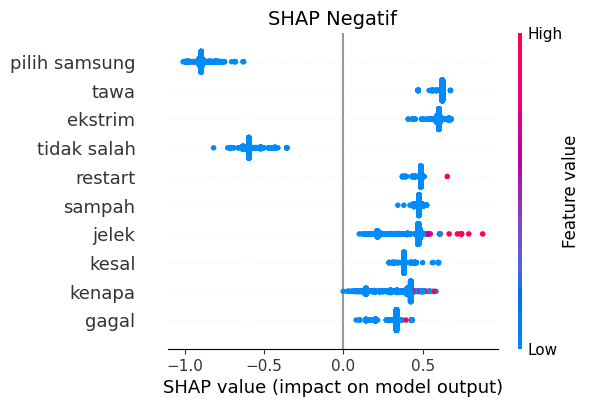

Class 1 SHAP summary plot:


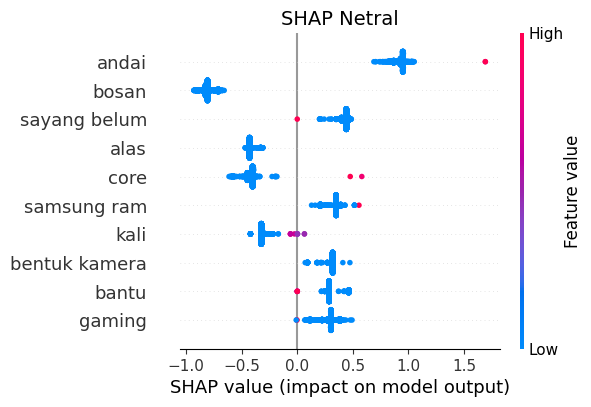

Class 2 SHAP summary plot:


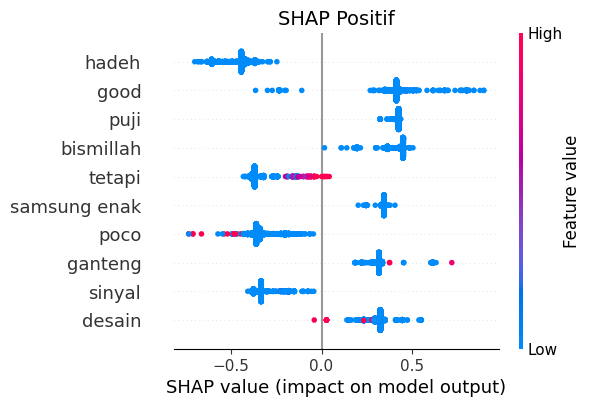

In [ ]:
FIG_WIDTH = 6
FIG_HEIGHT = 4
class_labels = {0: "Negatif", 1: "Netral", 2: "Positif"}
for class_idx in range(3):
    print(f"Class {class_idx} SHAP summary plot:")

    plt.figure()
    shap.summary_plot(
        shap_values.values[:, :, class_idx],
        X_test_dense,
        feature_names=vectorizer.get_feature_names_out(),
        plot_type="dot",
        max_display=10,
        show=False
        )
    plt.gcf().set_size_inches(FIG_WIDTH, FIG_HEIGHT)
    plt.tight_layout()
    plt.title(f"SHAP {class_labels[class_idx]}", fontsize=14)
    plt.show()

### Kurva PR AUC

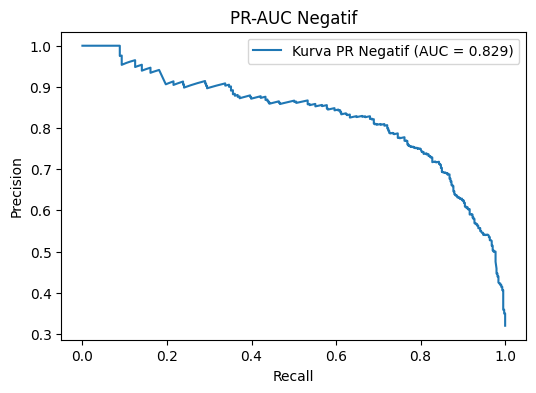

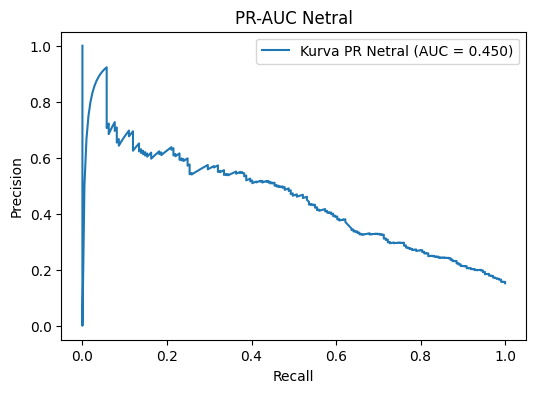

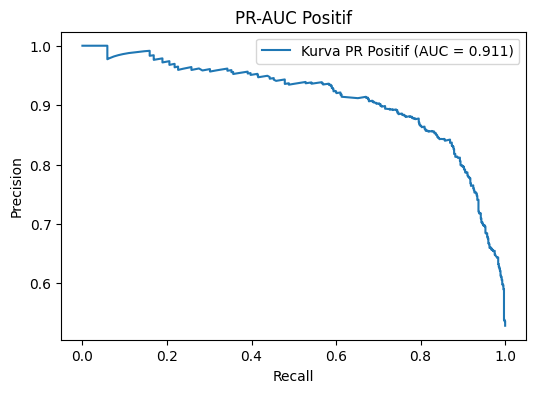

In [ ]:
for i in range(3):
  y_scores = y_probas[:, i]
  y_test_scores = (y_test == i).astype(int)

  precision, recall, thresholds = precision_recall_curve(
      y_test_scores,
      y_scores
  )
  pr_auc = auc(recall, precision)

  # Visualisasi
  plt.figure(figsize=(6, 4))
  plt.plot(recall, precision, label=f'Kurva PR {class_labels[i]} (AUC = {pr_auc:.3f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'PR-AUC {class_labels[i]}')
  plt.legend()
  plt.show()

### Threshold Tuning

In [ ]:
y_scores_netral = y_probas[:, 1]
y_test_netral = (y_test == 1).astype(int)

precision, recall, thresholds = precision_recall_curve(
    y_test_netral,
    y_scores_netral
)
pr_auc = auc(recall, precision)

thresholds_extended = np.append(thresholds, 1.0)
f1_scores = (2 * precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_extended[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Threshold Optimal untuk Kelas Netral: {optimal_threshold:.4f}")
print(f"F1-Score Maksimum: {max_f1_score:.4f}")
print(f"Presisi Threshold Optimal: {precision[optimal_idx]:.4f}")
print(f"Recall Threshold Optimal: {recall[optimal_idx]:.4f}")

Threshold Optimal untuk Kelas Netral: 0.4244
F1-Score Maksimum: 0.4933
Presisi Threshold Optimal: 0.4606
Recall Threshold Optimal: 0.5311


/tmp/ipython-input-192663527.py:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precision * recall) / (precision + recall)


In [ ]:
threshold_netral = optimal_threshold

y_pred_final = np.full(len(y_test), -1)

for i in range(len(y_probas)):
    probas = y_probas[i]
    if probas[1] >= threshold_netral:
        y_pred_final[i] = 1
    else:
        probas_non_netral = [probas[0], probas[2]]
        predicted_class_non_netral = np.argmax(probas_non_netral)
        if predicted_class_non_netral == 0:
            y_pred_final[i] = 0
        else:
            y_pred_final[i] = 2

print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       441
           1       0.46      0.53      0.49       209
           2       0.87      0.79      0.83       729

    accuracy                           0.75      1379
   macro avg       0.69      0.71      0.70      1379
weighted avg       0.77      0.75      0.76      1379



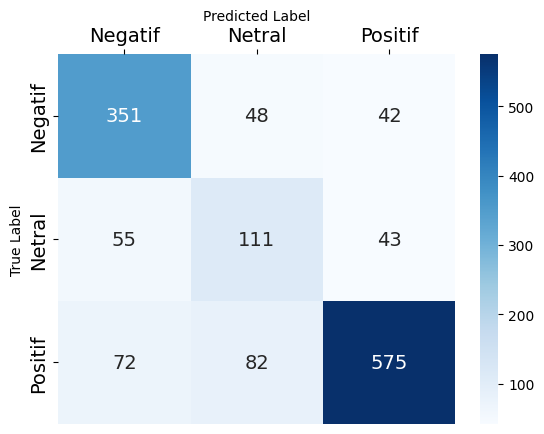

In [ ]:
cm = confusion_matrix(y_test, y_pred_final)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'], annot_kws={'size': 14})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVM

In [ ]:
# from sklearn.svm import LinearSVC
# svm = LinearSVC()
# svm.fit(X_train, y_train, sample_weight=sample_weights)

# y_pred = svm.predict(X_test)
# print(classification_report(y_test, y_pred))

### Logistic Regression

In [ ]:
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression(max_iter=200)
# logreg.fit(X_train, y_train, sample_weight=sample_weights)

# y_pred = logreg.predict(X_test)
# print(classification_report(y_test, y_pred))